## Classification of Activity Recognition from a Single Chest-Mounted Accelerometer
___

Build a supervised learning classification model for data downloaded from a [UCI hosted dataset](http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#). 

The dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
import sklearn

%matplotlib inline

In [3]:
# Can be loaded as a np array
csv1 = np.loadtxt('accelerometer/1.csv',delimiter=',')

In [4]:
# Remove 0 class from the last line of file, 1st column is index which can also be removed
csv1crop = np.array(csv1[:-1,1:],dtype=int)
print('Data size:',csv1crop.shape,'  Cropped [rows cols]:',np.subtract(csv1.shape,csv1crop.shape))

Data size: (162500, 4)   Cropped [rows cols]: [1 1]


In [5]:
# Check data type
csv1crop.dtype

dtype('int64')

In [6]:
# Check all possible classes
set(csv1crop[:,-1])

{1, 2, 3, 4, 5, 6, 7}

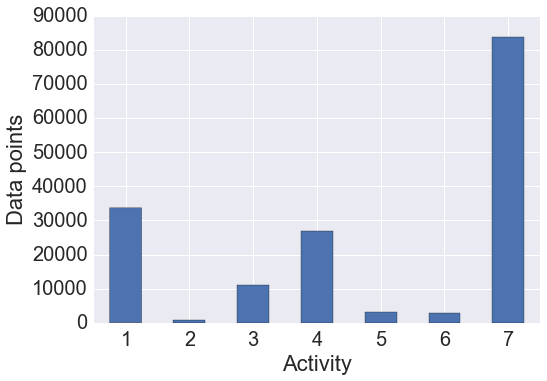

In [87]:
# Check for unequal data set, plot number of data points for each activity
plt.hist(csv1crop[:,-1],bins=7,range=(1,8),align='left',rwidth=0.5,label=[1,2,3,4,5,6,7])
plt.xlim(0.5,7.5)
plt.xlabel('Activity')
plt.ylabel('Data points')

In [88]:
df1 = DataFrame(csv1crop,columns=['X','Y','Z','Activity'])
# df1.head()

In [9]:
# sns.pairplot(df1,hue='Activity',size=3.5)

ERROR! Session/line number was not unique in database. History logging moved to new session 266


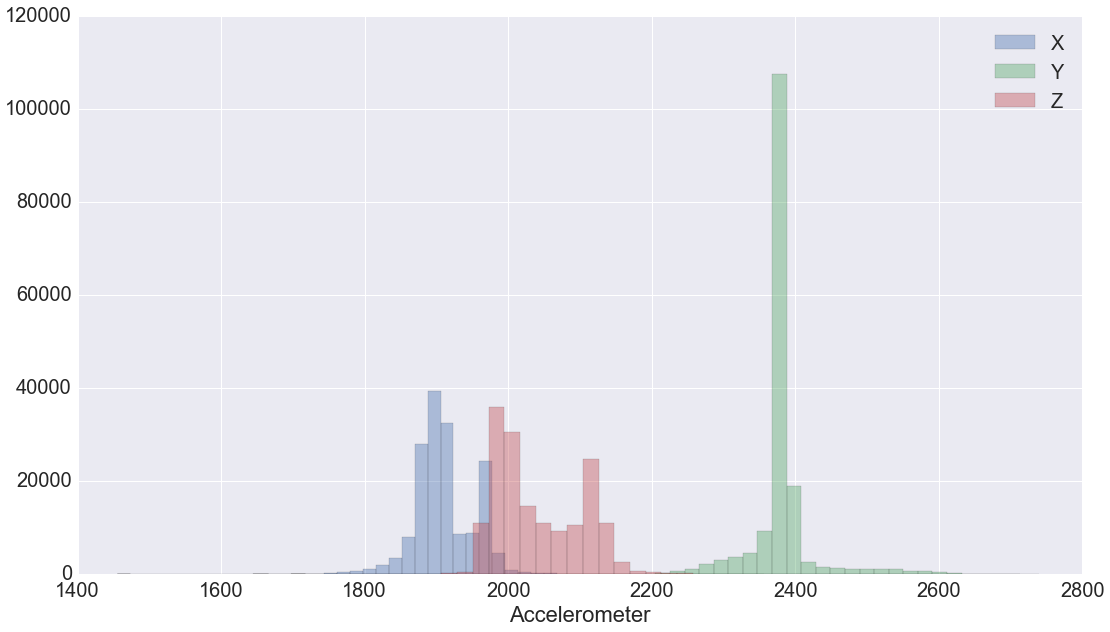

In [10]:
plt.figure(figsize=(18,10))
sns.set(font_scale=2)
sns.distplot(df1['X'],label='X',kde=False)
sns.distplot(df1['Y'],label='Y',kde=False)
sns.distplot(df1['Z'],label='Z',kde=False, axlabel='Accelerometer')
plt.legend()

In [157]:
# Create new variables consisting of ratios of acceleration in each direction

import itertools
from scipy.misc import factorial

nFeatures = 3
Pairs = list(itertools.combinations(list(range(nFeatures)),2))
Ratios = np.zeros((xx.shape[0],sum(range(nFeatures))))
for i in range(len(Pairs)):
    Ratios[:,i]=np.divide(xx[:,Pairs[i][0]],xx[:,Pairs[i][1]])
xxSup = np.hstack((xx,Ratios))

xxSup.shape

(162500, 6)

In [167]:
# Standardize data set to have mean zero and unit variance
from sklearn import preprocessing
Scaling = preprocessing.StandardScaler()

xxScaled = Scaling.fit_transform(xxSup)

np.mean(xxScaled,axis=0), np.std(xxScaled,axis=0)

(array([  1.92875801e-15,   5.03282574e-15,  -1.11627220e-15,
          5.55810695e-12,   6.60714483e-13,   1.31784263e-12]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.]))

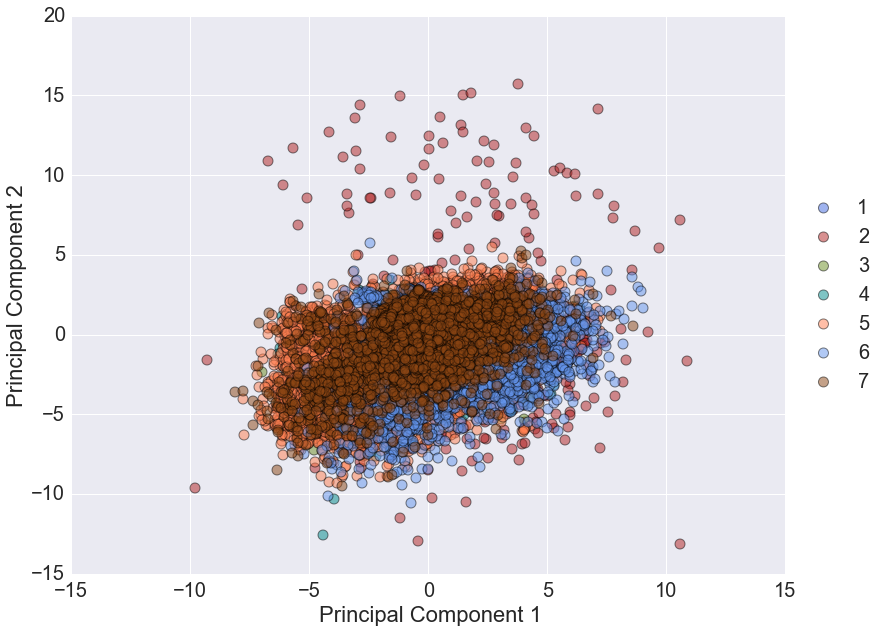

In [215]:
# 2D PCA
from sklearn.decomposition import PCA


yy = csv1crop[:,-1]
LblList= set(yy)

pca = PCA(n_components=2)
pca.fit(xxScaled)
PCACoeff = pca.transform(xxScaled)


ColorOpts = ['RoyalBlue', 'FireBrick', 'OliveDrab', 'DarkCyan', 'Coral', 
             'CornflowerBlue', 'SaddleBrown', 'YellowGreen', 'DarkViolet', 'DarkTurquoise']
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for i,c,class_name in zip(range(len(LblList)),ColorOpts,LblList):
    PointIdx = np.where(np.array(yy)==i)
    ax.scatter(PCACoeff[PointIdx,0], PCACoeff[PointIdx,1], c=c, label=class_name, s=100, linewidth=1, alpha=0.5) 

# Shrink axes box width by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put legend inside or to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)

plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
# PCAmax = np.amax(np.absolute(PCACoeff[:,:2]))
# limLog = np.floor(np.log10(PCAmax))
# limInt = np.ceil(PCAmax/(10**np.floor(np.log10(PCAmax))))
# lim = limInt*(10**limLog)
# plt.xlim(-1*lim,lim)
# plt.ylim(-1*lim,lim)

# plt.subplots_adjust(bottom=0.10,left=0.10,right=0.75,top=0.95,wspace=0.1,hspace=0.1)

In [294]:
# Multiclass machine learning algorithm, import packages

import warnings
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split,StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.learning_curve import validation_curve
from sklearn.grid_search import GridSearchCV

In [327]:
# Random shuffle data and take first nCrop rows

nCrop = 5000

ShuffleData = np.copy(xxScaled)
ShuffleData = np.hstack((ShuffleData,np.reshape(yy,(yy.shape[0],1))))
np.random.shuffle(ShuffleData)
X, Y = ShuffleData[:nCrop,:-1], np.array(ShuffleData[:nCrop,-1],dtype=int)

X.shape, Y.shape, X[:5,:], Y[:5]

((5000, 6),
 (5000,),
 array([[ 0.69685077, -0.6746771 ,  1.37386711,  0.90727297, -0.9927363 ,
         -1.48792792],
        [ 0.74604739, -1.77185553,  0.97070454,  1.64110557, -0.50496918,
         -1.7201949 ],
        [ 1.48399671, -0.36460494,  1.52505307,  1.28871947, -0.51532761,
         -1.45224268],
        [-1.17262085, -0.22149471, -0.05400032, -0.73144067, -0.95843861,
         -0.09326528],
        [-0.33627828,  0.01702234, -1.26348802, -0.26604114,  1.2147038 ,
          1.1045838 ]]),
 array([3, 5, 1, 7, 7]))

In [331]:
# Cross-validation of rbf svm classification

warnings.filterwarnings("ignore")

ClassNames = list('1234567')

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.4,random_state=None)
params_test = {'gamma': list(np.logspace(-6,1,8)), 'C': list(np.logspace(0,3,4))}
gridclf = GridSearchCV(SVC(), params_test, cv=5, scoring='f1_weighted',n_jobs=2)
gridclf.fit(X_train, Y_train)
print('Best parameters:',gridclf.best_params_)
Y_pred = gridclf.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=ClassNames))


#gamma_rng = np.logspace(-6,2,9)
#scores_train, scores_test = validation_curve(SVC(),X,Y, param_name='gamma', param_range=gamma_rng, 
#                                             cv=5, scoring='f1_weighted', n_jobs=2)

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.4,random_state=None)

#for i in range(1,11):
#    svmclf = sklearn.svm.SVC(C=0.1*i,kernel='rbf')
#    Y_pred = svmclf.fit(X_train, Y_train).predict(X_test)
#    print('C is {:1f}'.format(0.1*i))
#    print(classification_report(Y_test, Y_pred, target_names=ClassNames))

Best parameters: {'gamma': 10.0, 'C': 1.0}
             precision    recall  f1-score   support

          1       0.98      0.94      0.96       405
          2       0.33      0.17      0.22         6
          3       0.80      0.26      0.40       152
          4       0.66      0.83      0.73       337
          5       0.50      0.03      0.05        38
          6       0.00      0.00      0.00        36
          7       0.85      0.94      0.89      1026

avg / total       0.82      0.83      0.81      2000



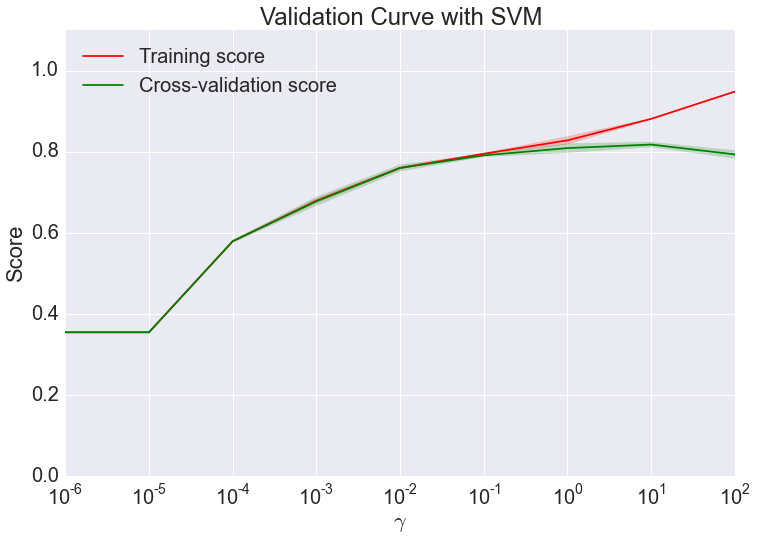

In [281]:
# Plot validation scores

train_scores_mean = np.mean(scores_train, axis=1)
train_scores_std = np.std(scores_train, axis=1)
test_scores_mean = np.mean(scores_test, axis=1)
test_scores_std = np.std(scores_test, axis=1)

plt.figure(figsize=(12,8))
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(gamma_rng, train_scores_mean, label="Training score", color="r")
plt.fill_between(gamma_rng, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(gamma_rng, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(gamma_rng, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")

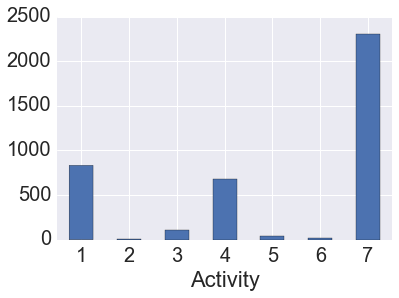

In [297]:
plt.hist(Y_pred,bins=7,range=(1,8),align='left',rwidth=0.5,label=[1,2,3,4,5,6,7])
plt.xlim(0.5,7.5)
plt.xlabel('Activity')

In [200]:
# skf = StratifiedKFold(Y,n_folds=10,shuffle=True)

# Y_pred = OneVsRestClassifier(LinearSVC(C=1,random_state=None)).fit(X_train, Y_train).predict(X_test)